<a href="https://colab.research.google.com/github/thesalmonification/DSCI400_Revamp/blob/master/Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Helper Funcs

### Imports

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
from collections import defaultdict
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from google.colab import drive

drive.mount('/content/drive')
# Need to manually move images from personal drive to shared drive
#fig_path = '/content/drive/My Drive/test/'
shared_path = '/content/drive/Shared drives/DSCI400_Revamp/Exploration_Plots/'

# Paths for generated images
label_key_path = '/content/drive/Shared drives/DSCI400_Revamp/Label_Data_Keys.csv'
wav_key_path = '/content/drive/Shared drives/DSCI400_Revamp/Waveform_Data_Keys.csv'
label_hdf_path = '/content/drive/Shared drives/DSCI400_Revamp/Label_Data.h5'
wav_hdf_path = '/content/drive/Shared drives/DSCI400_Revamp/Waveform_Data.h5'

# Relevant dictonaries to help code simplicity
# 
labels = {0:"Emotion", 1:"Arousal", 2:"Valence", 3:"Control", 4:"Predictability"}
channels = {0:'Fp1', 1:'AF3', 2:'F3', 3:'F7', 4:'FC5', 5:'FC1', 6:'C3', 7:'T7', 8:'CP5', 9:'CP1', 10:'P3',
       11:'P7', 12:'PO3', 13:'O1', 14:'Oz', 15:'Pz', 16:'Fp2', 17:'AF4', 18:'Fz', 19:'F4', 20:'F8', 21:'FC6',
       22:'FC2', 23:'Cz', 24:'C4', 25:'T8', 26:'CP6', 27:'CP2', 28:'P4', 29:'P8', 30:'PO4', 31:'O2'}
emotions = {0:"Neutral", 1:"Anger", 2:"Disgust", 3:"Fear", 4:"Happy", 5:"Sad", 6:"Surprise", 11:"Amusement", 12:"Anxiety"}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Helper Functions

In [0]:
def heat2D(x, y):
  """
  Creates a matrix that contains the counts of every label value pair occurance.

  Arguments:
  x -- array containing values for one label
  y -- array containing values for second label

  Returns:
  A matrix where each column gives the count of label pairs:
    1st row: label 1 value
    2nd row: label 2 value
    3rd row: count
  """
  # Initialize data structures
  counts = {}
  pairs = [[],[],[]]
  for i in range(len(x)):
    counts[x[i]] = defaultdict(int)

  # Counts pair occurances
  for i in range(len(x)):
    counts[x[i]][y[i]] += 1

  # Create matrix from dictionary
  for x in counts:
    for y in counts[x]:
      pairs[0].append(x)
      pairs[1].append(y)
      pairs[2].append(counts[x][y])
  return (pairs)

# Data Exploration

### Label Matrix Creation: DEPRECATED

In [0]:
# #This code block is deprecated (2/3/2020); we no longer use CSV files for analysis

# # Creating a single matrix that contains all the labels for every session.
# # Each row of the matrix is a different label value

# # Define path to labels and initialize matrix
# label_path = '/content/drive/Shared drives/DSCI400_Revamp/Label_CSV/'
# label_matrix = [[],[],[],[],[]]

# # Iterate through label data files and 
# for file in os.listdir(label_path):
#   frame = pandas.read_csv(label_path+file)
#   array = frame.to_numpy()[:,1]
#   for i in range(0,5):
#     label_matrix[i].append(array[i])


### Label Matrix Creation: Updated 2/3/2020

In [0]:
#The old form of label matrix creation relied on CSV files which no longer exist.
#This new format uses HDF5 to create the label matrix

# Creating a single matrix that contains all the labels for every session.
# Each row of the matrix is a different label value

# Extract label data hdf keys and initialize matrix
label_keys = pandas.read_csv(label_key_path, header=None)
label_keys = list(label_keys[0])
label_matrix = [[],[],[],[],[]]

# Iterate though label files and consildate into matrix
for key in label_keys:
  frame = pandas.read_hdf('/content/drive/Shared drives/DSCI400_Revamp/Label_Data.h5',key=key)
  array = frame['Value'].iloc[:5].to_numpy()#[:,1]
  for i in range(0,5):
    label_matrix[i].append(int(array[i]))



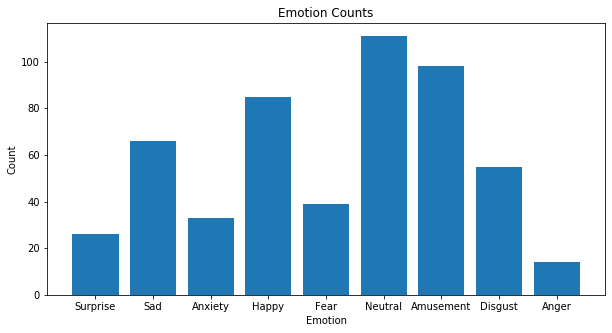

In [8]:
# Counting occurrances of emotions
emot_count = defaultdict(int)
for emotion in label_matrix[0]:
  emot_count[emotions[emotion]] += 1
#print(emot_count)

# Print emotion counts as a histogram
fig = plt.figure(figsize=(10,5))
plt.bar(emot_count.keys(), emot_count.values())
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion Counts")
fig.savefig(shared_path+"Emot_Count")
plt.show()

### Label Correlation Heat Plots

In [0]:
# Creates scatter plots counting the number of label value pair occurances for
# every pair.

# # Create folders for scatter heat plots, ONLY NECESSAY FOR FIRST RUN
# os.mkdir(shared_path+"Scatter_Heat_Plots")

# Iterate through every possible label pairing
for a in range(0,5):
  for b in range(a+1,5):
    #Create heat map matrix
    x = label_matrix[a]
    y = label_matrix[b]
    heat = heat2D(x, y)
    #print(labels[a] + " vs " + labels[b])
    #print(np.array(heat))

    #Plot
    fig = plt.figure()
    plt.scatter(heat[0], heat[1], c=heat[2], cmap="rainbow")
    plt.title("%s vs %s" % (labels[a], labels[b]))
    plt.ylabel(labels[b])
    plt.xlabel(labels[a])
    plt.colorbar()
    #fig.savefig(fig_path+labels[a]+"_"+labels[b])
    fig.savefig(shared_path+"Scatter_Heat_Plots/"+labels[a]+"_"+labels[b])
    # plt.close()
    fig.show()


### Individual Emotion Bar Charts

In [0]:
# Creates bar charts counting the number of label value pair (excluding Emotion 
# value) occurances for every pair in sessions with the same Emotion value.

# # Create folders for bar plots, ONLY NECESSAY FOR FIRST RUN
# os.mkdir(shared_path+"Emotion_Specific_Corr")

x = label_matrix[0]
# Iterate through non-Emotion labels
for b in range(1,5):
  # Generate count/ heat map
  y = label_matrix[b]
  heat = heat2D(x, y)
  
  # Iterate through each emotion
  for emot in emotions:
    emot_heat = [[],[]]
    # Extract counts for relevant Emotion
    for index in range(len(heat[0])):
      if (heat[0][index] == emot):
        emot_heat[0].append(heat[1][index])
        emot_heat[1].append(heat[2][index])

    # Plot
    # print(labels[b]+" for Emotion: "+emotions[emot])
    # print(np.array(emot_heat))
    fig = plt.figure()
    plt.bar(emot_heat[0], emot_heat[1])
    plt.title("%s for Emotion: %s" % (labels[b], emotions[emot]))
    plt.ylabel("Occurances")
    plt.xlabel(labels[b]+" value")
    fig.savefig(shared_path+"Emotion_Specific_Corr/"+labels[b]+"_"+emotions[emot])
    # plt.close()
    fig.show()

### FFT Exploration

FFTs

In [0]:
# Computes Fast Fourier Transforms (FFTs) for every channel in every session

# Extract keys for session hdf files (EEG data & labels)
key_frame = pandas.read_csv(wav_key_path, header=None)
keys = key_frame.to_numpy()[:,0].tolist()

# # Create folders for FFTs, ONLY NECESSAY FOR FIRST RUN
# os.mkdir(shared_path+"FFTs")
# os.mkdir(shared_path+"FFTs/bySession")
# os.mkdir(shared_path+"FFTs/byChannel")
# for key in keys:
#  os.mkdir(shared_path+"FFTs/bySession/"+key)
# for chnl_i in channels:
#  os.mkdir(shared_path+"FFTs/byChannel/"+channels[chnl_i])


# Iterate through every file and calculate FFTs of every channel
i = 440
for key in keys[440:]:
  i += 1
  print(i, key)

  # Extract session emotion for title
  label_data = pandas.read_hdf(label_hdf_path, key=key+"_labels")
  emot = emotions[int(label_data.to_numpy()[0,0])]

  # Extract EEG data and iterate through every channel
  wav_data = pandas.read_hdf(wav_hdf_path, key=key)
  for chnl_i in channels:
    # Extract desired channel and remove DC offset
    channel = wav_data.loc[:, channels[chnl_i]].to_numpy()
    channel = channel - np.average(channel)
    
    # Perfom FFT
    transf = fft(channel.tolist())
    freq = fftfreq(len(channel)) * 256

    # Calculate indices corresponding to brainwave frequencies
    cutoff_s = int(0.5*len(channel)/256)
    cutoff_e = int(30*len(channel)/256)

    # Plot FFT and save figure
    fig = plt.figure()
    plt.plot(freq[cutoff_s: cutoff_e], abs(transf[cutoff_s: cutoff_e]))
    plt.title("Ch %s in Session %s (Emot: %s)" % (channels[chnl_i], key, emot))
    plt.ylabel("Magnitude")
    plt.xlabel("Frequency (Hz)")
    fig.savefig(shared_path+"FFTs/bySession/"+key+"/"+channels[chnl_i])
    fig.savefig(shared_path+"FFTs/byChannel/"+channels[chnl_i]+"/"+key)
    plt.close()

    del channel
    del transf
    del freq
    del cutoff_s
    del cutoff_e
    del fig

    print(channels[chnl_i])
  
  del label_data
  del emot
  del wav_data 



### Clustering

In [0]:
# Basic clustering code to refamiliarize with python k-means

pca = PCA(n_components = 5).fit(label_matrix)
#print(pca.components_.shape)
fig_pca = plt.figure()
plt.scatter(pca.components_[0], pca.components_[1])
plt.title("PCA")
fig_pca.show()

data = np.transpose(np.array(label_matrix))
#print(data.shape)

kmeans = KMeans(n_clusters = 2).fit(data)
#print(kmeans.labels_.shape)
fig_km = plt.figure()
plt.scatter(pca.components_[0], pca.components_[1], c=kmeans.labels_, cmap="rainbow")
fig_km.show()